# Intrusion Detection Computer Vision System

## 1. Introduction

Given the following following tasks:
- For each frame of an input video, the system needs detect and display some blobs (either by coloring them on a black background or by showing the countours on top of the original video) and produce a textual output listing the found blobs and their meaningful features.
- The system is required to discriminate between a present blob and a false one originated by the removal of an object from the background.

The proposed solution implements the developed library `intrusiondetection` and this notebook shows the step-by-step operations computed to achieve the final outputs displaying the computations on some key frames alongside considerations over the made choices. 

In [22]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

from intrusiondetection.parameters import ParameterList
from intrusiondetection.utility import distance_euclidean
from intrusiondetection.model import MorphOp, MorphOpsSet, Video, Background

# Only for jupyter notebook visualization
%matplotlib inline 

input_video_path = "rilevamento-intrusioni-video.avi"
video = Video(input_video_path)

key_frame_index_1 = 124
key_frame_index_2 = 150
key_frame_index_3 = 317

### 1.1. Considerations

The input video presents the following characteristics:
- 12 fps
- ~41s
- 320x240 pixels
- 8 bit/pixel (256 gray levels)

By observing its contents some details show up:
- The video presents a meaningful amount of noise, it will be then necessary to apply binary morphology operators to improve the obtained result.
- The amount of lighting in the scene of the video changes slightly during the corse of it, it will be necessary to implement a dynamic background computation, technique which is possible thanks to the FPS rate not extremely small.
- The person changes its moving velocity in the course of the video, the adaptation rate of the dynamic background should be tuned accordingly.

## 2. Background Estimation

### 2.1. Initial Background

To estimate a good background for the scene, it's necessary to perform an interpolation between some chosen frames of the video, the parameters of the operation are:

- The different interpolation function used: `np.mean` and `np.median` have been considered.
- The amount of initial frames is tuned based on a tradeoff between the smallest and most stable number, therefore the considered values are `40`, `80`, `120`

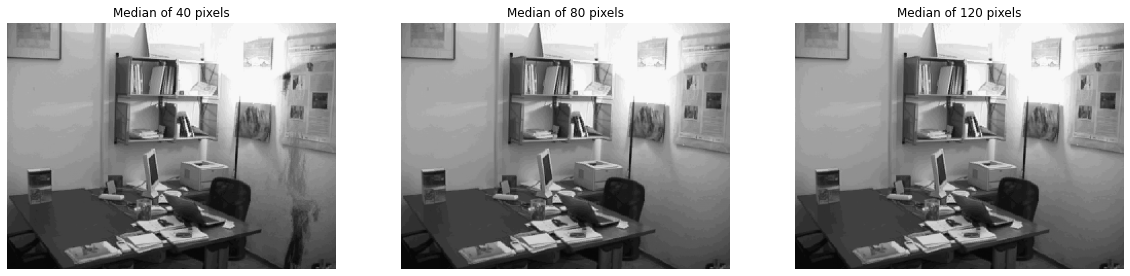

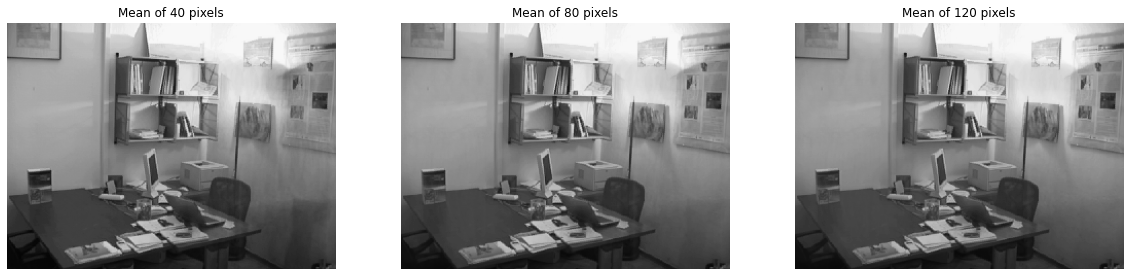

In [23]:
from intrusiondetection.utility import subplot_images

bg_medn_40 = Background(input_video_path, np.median, 40)
bg_medn_80 = Background(input_video_path, np.median, 80)
bg_medn_120 = Background(input_video_path, np.median, 120)
bg_mean_40 = Background(input_video_path, np.mean, 40)
bg_mean_80 = Background(input_video_path, np.mean, 80)
bg_mean_120 = Background(input_video_path, np.mean, 120)

subplot_images([
    {
        'object': bg_medn_40,
        'key': 'image',
        'title': 'Median of 40 pixels'
    },
    {
        'object': bg_medn_80,
        'key': 'image',
        'title': 'Median of 80 pixels'
    },
    {
        'object': bg_medn_120,
        'key': 'image',
        'title': 'Median of 120 pixels'
    }
])

subplot_images([
    {
        'object': bg_mean_40,
        'key': 'image',
        'title': 'Mean of 40 pixels'
    },
    {
        'object': bg_mean_80,
        'key': 'image',
        'title': 'Mean of 80 pixels'
    },
    {
        'object': bg_mean_120,
        'key': 'image',
        'title': 'Mean of 120 pixels'
    }
])

It's notable that with a frame number below 80 the resulting image looks unclear using both functions. 

By performing various tests, it has been noticed that the output doesn't result in a significant change of quality by increasing the value over 80 frame.

It has also been observed that the `np.median` function achieves more stable solutions.

Therefore the chosen values are `80` frames using the `np.median` interpolation.

In [24]:
initial_background = bg_medn_80

### 2.2. Background update
The two main approaches to obtain a dynamic background are `blind` and `selective`.

The following section shows an example of a blind background computed using an adaption rate of `0.1`

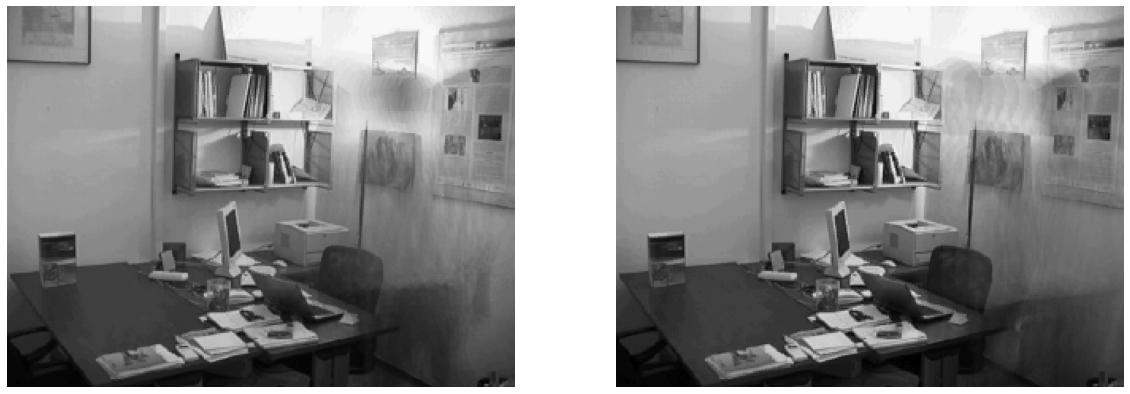

In [25]:
blind_backgrounds = video.process_backgrounds('blind', initial_background, 0.1)
key_frame_background_1 = blind_backgrounds[key_frame_index_1]
key_frame_background_2 = blind_backgrounds[key_frame_index_2]

subplot_images([
    {
        'object': key_frame_background_1,
        'key': 'image',
        'title': ''
    },
    {
        'object': key_frame_background_2,
        'key': 'image',
        'title': ''
    }
])

For the selective approach, there are also a threshold and a distance function parameters to compute the subtraction between the frame and the background. 

As a further improvement, some binary morphology operators are applied to obtain a more meaningful background mask:
- 3x3 Opening - 
- 3x3 Closing
- 25x25 Dilation

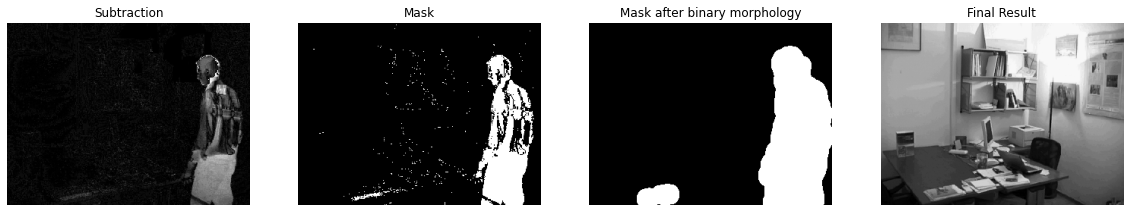

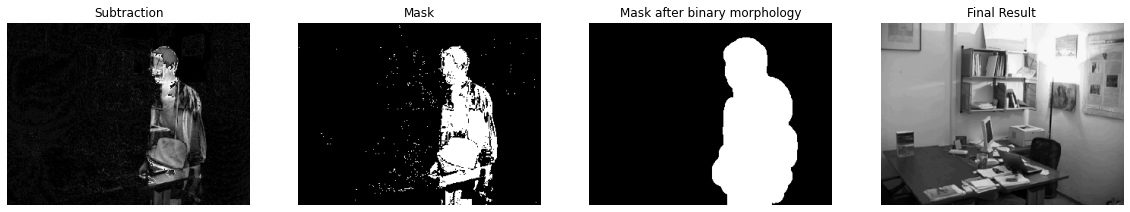

In [26]:
selective_backgrounds = video.process_backgrounds('selective', initial_background, 0.1, 37, distance_euclidean, MorphOpsSet(
    MorphOp(cv2.MORPH_OPEN, (3,3), iterations=1),
    MorphOp(cv2.MORPH_CLOSE, (3,3), iterations=1),
    MorphOp(cv2.MORPH_DILATE, (25,25), cv2.MORPH_ELLIPSE)
))
key_frame_background_1 = selective_backgrounds[key_frame_index_1]
key_frame_background_2 = selective_backgrounds[key_frame_index_2]

key_frame_background_1.display_row([
    {
        'key': 'subtraction',
        'title': 'Subtraction'
    },
    {
        'key': 'mask_raw',
        'title': 'Mask'
    },
    {
        'key': 'mask_refined',
        'title': 'Mask after binary morphology'
    },
    {
        'key': 'image',
        'title': 'Final Result'
    },
])

key_frame_background_2.display_row([
    {
        'key': 'subtraction',
        'title': 'Subtraction'
    },
    {
        'key': 'mask_raw',
        'title': 'Mask'
    },
    {
        'key': 'mask_refined',
        'title': 'Mask after binary morphology'
    },
    {
        'key': 'image',
        'title': 'Final Result'
    },
])

A selective background clearly obtains better results, it is therefore the preferred method.

## 3. Change Detection

### 3.1. Background Subtraction

To perform the change detection the first step is to subtract the current frame with respect to the corresponding background:

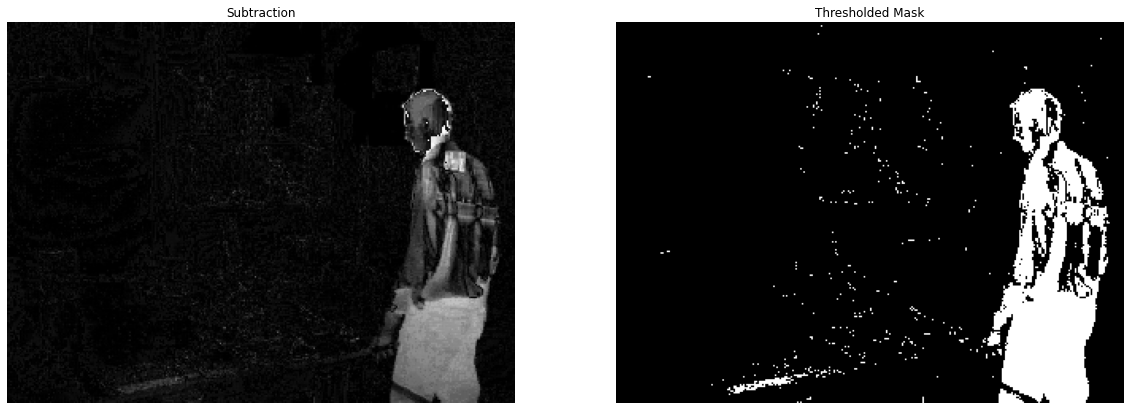

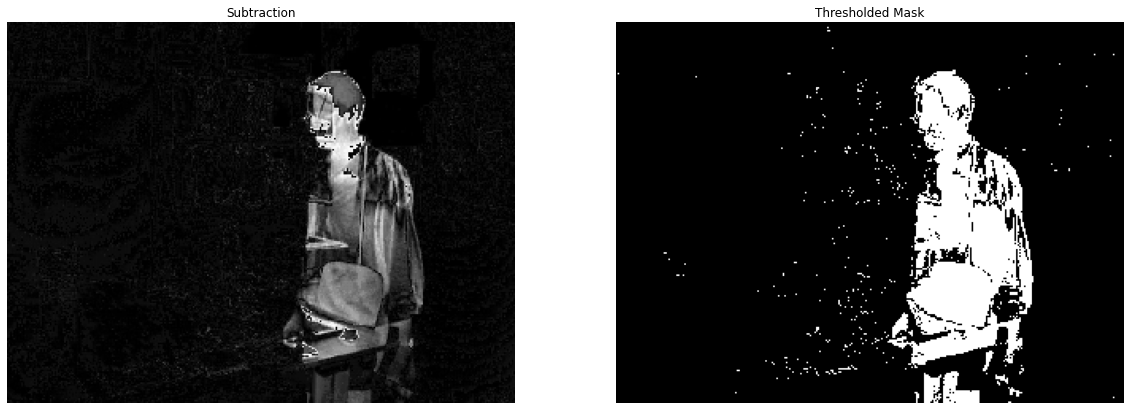

In [27]:
key_frame_1 = video.frames[key_frame_index_1]
key_frame_1.apply_change_detection(selective_backgrounds[key_frame_index_1], 37, distance_euclidean)

key_frame_2 = video.frames[key_frame_index_2]
key_frame_2.apply_change_detection(selective_backgrounds[key_frame_index_2], 37, distance_euclidean)

key_frame_1.display_row([
    {
        'key': 'subtraction',
        'title': 'Subtraction'
    },
    {
        'key': 'mask_raw',
        'title': 'Thresholded Mask'
    }
])

key_frame_2.display_row([
    {
        'key': 'subtraction',
        'title': 'Subtraction'
    },
    {
        'key': 'mask_raw',
        'title': 'Thresholded Mask'
    }
])

### 3.2. Binary Morphology

We then use binary morphology operators:
- 3x3 Opening to remove the noise
- 45x70 Closing 
- 6x6 Opening 

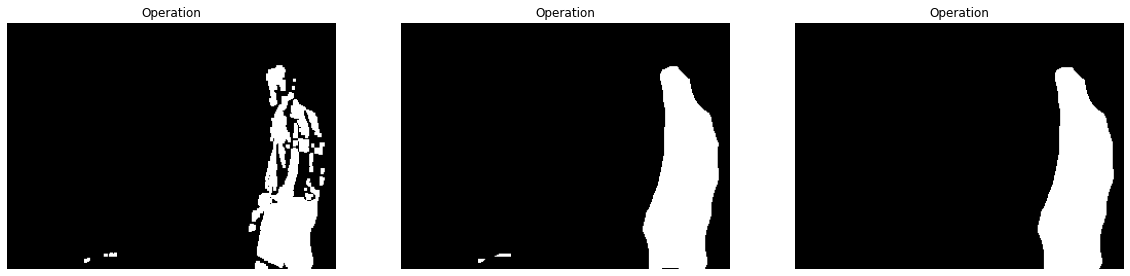

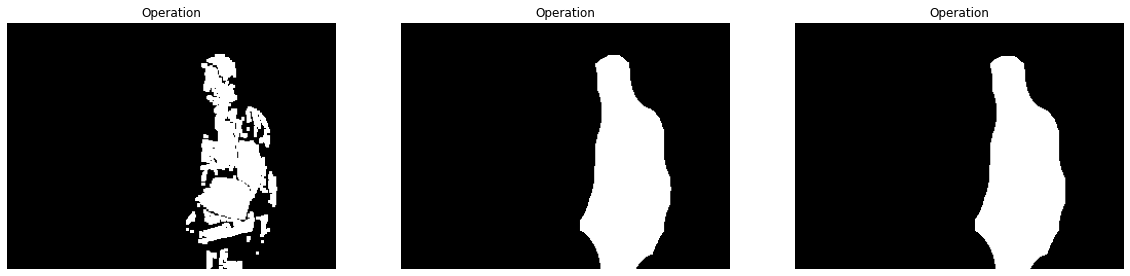

In [28]:
ms1 = MorphOpsSet(
    MorphOp(cv2.MORPH_OPEN, (3,3))
)

ms2 = MorphOpsSet(
    MorphOp(cv2.MORPH_OPEN, (3,3)),
    MorphOp(cv2.MORPH_CLOSE, (45,70), cv2.MORPH_ELLIPSE),
)

ms3 = MorphOpsSet(
    MorphOp(cv2.MORPH_OPEN, (3,3)),
    MorphOp(cv2.MORPH_CLOSE, (45,70), cv2.MORPH_ELLIPSE),
    MorphOp(cv2.MORPH_OPEN, (6,6), cv2.MORPH_ELLIPSE),
)

frame1_op1, frame1_op2 = key_frame_1.copy(), key_frame_1.copy()
frame1_op1.apply_morphology_operators(ms1)
frame1_op2.apply_morphology_operators(ms2)
key_frame_1.apply_morphology_operators(ms3)

frame2_op1, frame2_op2 = key_frame_2.copy(), key_frame_2.copy()
frame2_op1.apply_morphology_operators(ms1)
frame2_op2.apply_morphology_operators(ms2)
key_frame_2.apply_morphology_operators(ms3)

subplot_images([
    {
        'object': frame1_op1,
        'key': 'mask_refined',
        'title': 'Operation'
    },
    {
        'object': frame1_op2,
        'key': 'mask_refined',
        'title': 'Operation'
    },
    {
        'object': key_frame_1,
        'key': 'mask_refined',
        'title': 'Operation'
    }
])

subplot_images([
    {
        'object': frame2_op1,
        'key': 'mask_refined',
        'title': 'Operation'
    },
    {
        'object': frame2_op2,
        'key': 'mask_refined',
        'title': 'Operation'
    },
    {
        'object': key_frame_2,
        'key': 'mask_refined',
        'title': 'Operation'
    }
])

## 4. Blob Analysis

### 4.1. Blob Labeling

The labeling of the obtained image is performed using the `cv2.connectedComponents` function.

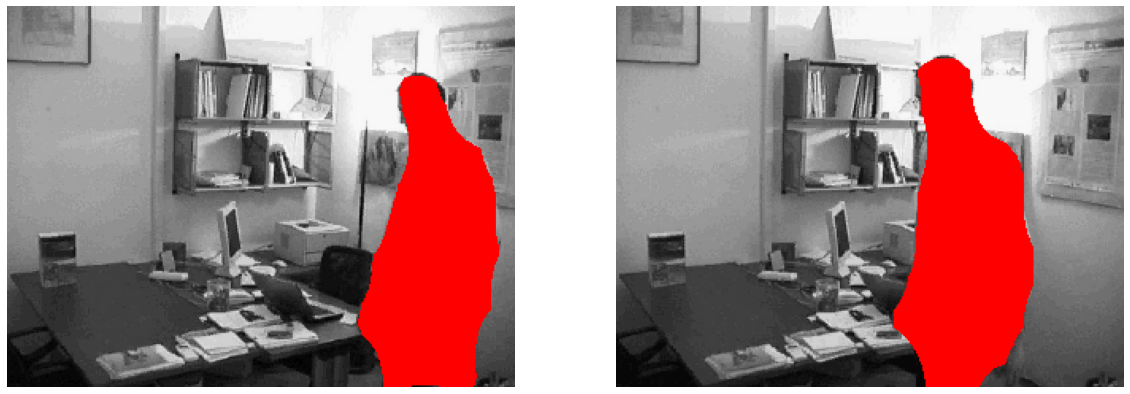

In [21]:
key_frame_1.apply_blob_analysis([], 5000)
key_frame_2.apply_blob_analysis([], 5000)

subplot_images([
    {
        'object': key_frame_1,
        'key': 'blobs_labeled',
        'title': "",
    },
    {
        'object': key_frame_2,
        'key': 'blobs_labeled',
        'title': "",
    },
])
#TODO curr_frame.apply_blob_labeling()
#TODO curr_frame.show('blobs_labeled')

### 4.2. Selected Features

The meaningful features considered are:
- Area
- Perimeter
- Barycentre

### 4.3. Label Remapping
It is necessary to keep continuity between the blob labeling in subsequential frames, therefore, a dissimilarity function is computed to seek for correspondances between the current and previous blobs.
The label are then remapped to match the labels in the previous frame.
The blobs are displayed with their label printed on the barycentre.

The function is defined as: TODO

The dissimilarity function holds a threshold parameter to define an upper bound for a maximum dissimilarity above which two blobs are always considered different.

TODO: Mostrare dissimilarity tra tutti gli oggetti per dare un'idea della media?

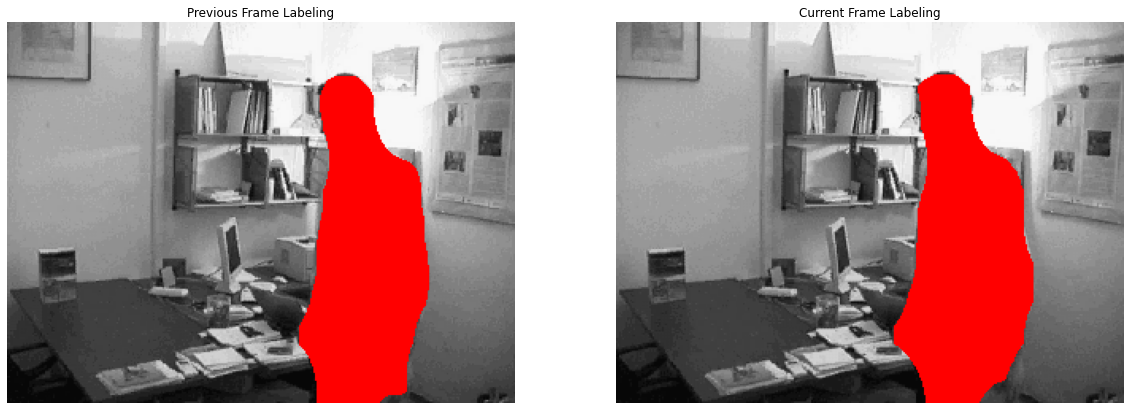

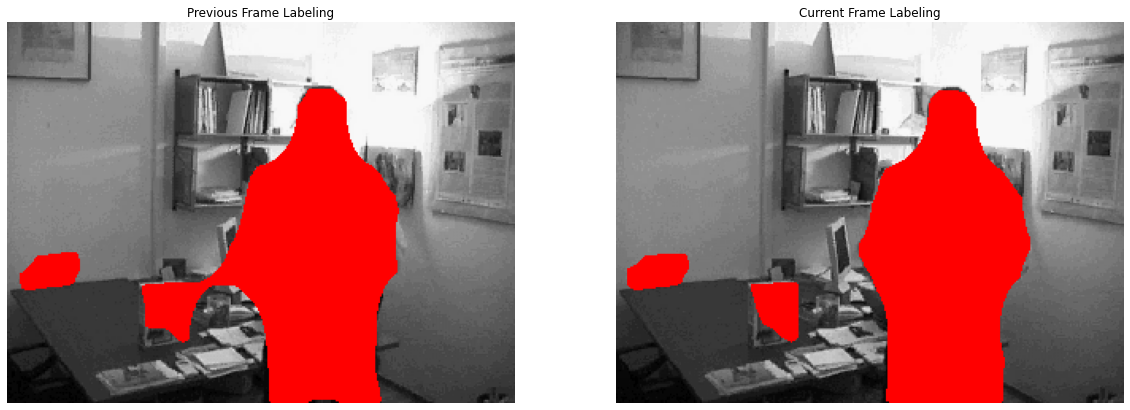

In [9]:
from intrusiondetection.parameters import ParameterSet

params = ParameterSet({
    "input_video": "rilevamento-intrusioni-video.avi",
    "output_directory": "output"
}, {
    "threshold": 37,
    "distance": distance_euclidean,
    "morph_ops": MorphOpsSet(
        MorphOp(cv2.MORPH_OPEN, (3,3)),
        MorphOp(cv2.MORPH_CLOSE, (45,70), cv2.MORPH_ELLIPSE),
        MorphOp(cv2.MORPH_OPEN, (6,6), cv2.MORPH_ELLIPSE),
    ),
    "background_threshold": 37,
    "background_distance": distance_euclidean,
    "background_morph_ops": MorphOpsSet(MorphOp(cv2.MORPH_CLOSE, (3,3), iterations=1),MorphOp(cv2.MORPH_OPEN, (3,3), iterations=2), MorphOp(cv2.MORPH_DILATE, (25,10)), MorphOp(cv2.MORPH_ERODE, (15,5))),
    "alpha": 0.1,
    "background": {
        "frames": [100],
        "interpolation": [np.median]
    }
})

key_frame_prev_1 = video.frames[key_frame_index_1 - 1]
key_frame_prev_1.intrusion_detection(params, selective_backgrounds[key_frame_index_1 - 1], [])

key_frame_prev_2 = video.frames[key_frame_index_2 - 1]
key_frame_prev_2.intrusion_detection(params, selective_backgrounds[key_frame_index_2 - 1], [])

key_frame_1.apply_blob_analysis(key_frame_prev_1.blobs, 5000)
key_frame_2.apply_blob_analysis(key_frame_prev_2.blobs, 5000)
#TODO curr_frame.apply_blob_linkage(dissimilarity_threshold)
#TODO curr_frame.show('blobs_remapped')

subplot_images([
    {
        'object': key_frame_prev_1,
        'key': 'blobs_remapped',
        'title': 'Previous Frame Labeling'
    },
    {
        'object': key_frame_1,
        'key': 'blobs_remapped',
        'title': 'Current Frame Labeling'
    }
])

subplot_images([
    {
        'object': key_frame_prev_2,
        'key': 'blobs_remapped',
        'title': 'Previous Frame Labeling'
    },
    {
        'object': key_frame_2,
        'key': 'blobs_remapped',
        'title': 'Current Frame Labeling'
    }
])

### 4.4. Classification 
To classify the blobs, a function of their features is computed.
The function is defined as: TODO

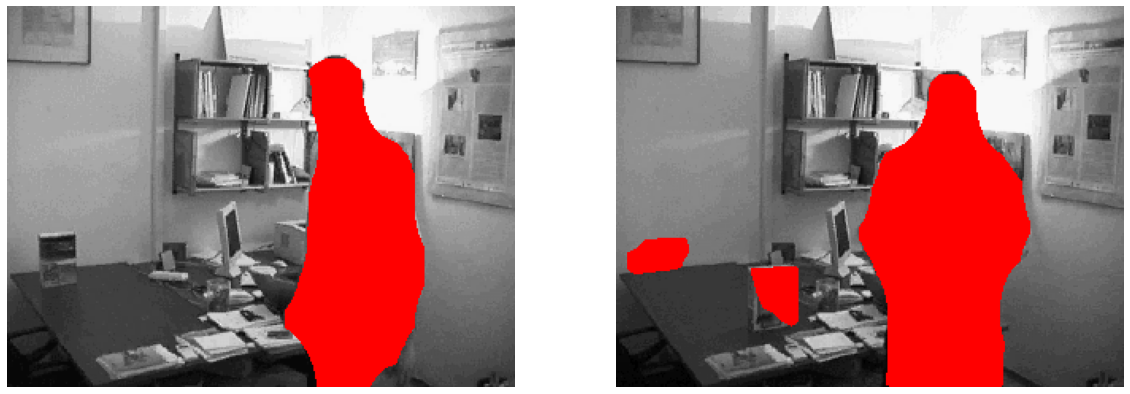

In [19]:
subplot_images([
    {
        'object': key_frame_1,
        'key': 'blobs_classified',
        'title': ''
    },
    {
        'object': key_frame_2,
        'key': 'blobs_classified',
        'title': ''
    }
])

## 5. True/False Object Recognition

To apply the object recognition the selected approach is the evaluation of the edges strength, such that, when the contours of a found blob presents sharp edges in the original image, it is considered to be present, otherwise it is labeled as fake.

The computation is performed by using a Sobel operator returning a smoothed edge score not taking into account the large amount of noise present in the original frame. 

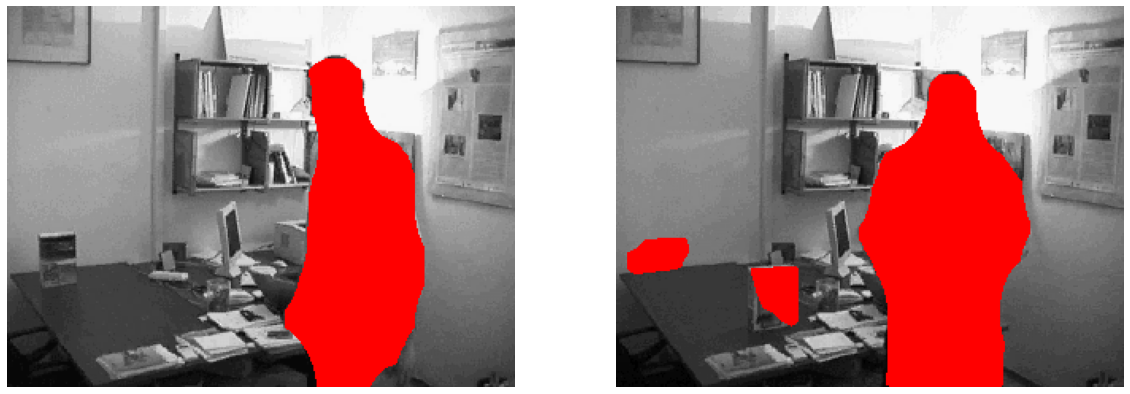

In [17]:
subplot_images([
    {
        'object': key_frame_1,
        'key': 'blobs_refined',
        'title': ''
    },
    {
        'object': key_frame_2,
        'key': 'blobs_refined',
        'title': ''
    }
])

## 6. Output Generation

### 6.1. Text Output

A CSV file is then generated, for each frame the following informations are stored:
- Frame Index
- Number of Detected Objects
- Then a row for each detected object is printed listing this features:
   - Object Label
   - Area
   - Perimeter
   - Classification

### 6.2. Video Output

The graphical output shows the contours of the found objects, the color of the contour depends on the object classification:
- Person: Blue
- True Object: Green
- Fake Object: Red

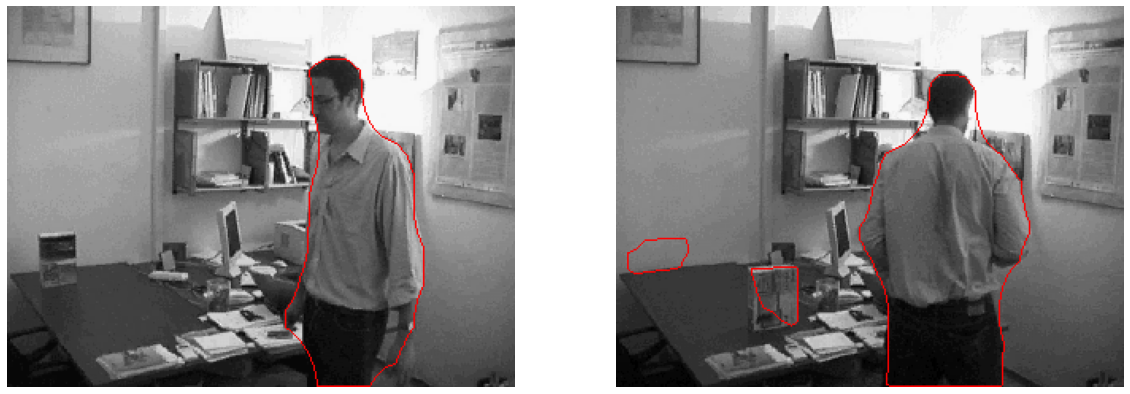

In [16]:
subplot_images([
    {
        'object': key_frame_1,
        'key': 'blobs_contours',
        'title': ''
    },
    {
        'object': key_frame_2,
        'key': 'blobs_contours',
        'title': ''
    }
])